## Violating Local Realism

## Section 1: The Bell Test Demo
![](img/BellTest.png)

Using Qiskit to calculate the CHSH inequality

In this demo, we will use Qiskit to prove that we can violate local realism. We will make use of IBMs quantum computers in making our computations 

1. Import the needed Python libraries

In [1]:
import numpy as np  
from math import pi

2. Import the Qiskit libraries

In [2]:
import qiskit as q
from qiskit import IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.ibmq import least_busy

3. Add import to help track jobs on ibmq by adding widget to top left

In [3]:
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

4. Write helper method to return the counts for a specific measurement basis Q, R, S, or T.
   The input of the helper method is the counts obtained from simulation for a measured basis, either Q, R, S, or T
   The output of the method is the statistical count for a measured state if it's present else the return value is 0

In [4]:
def check(counts,name):
    try:
        return counts[name]
    except:
        return 0

5. Writing Actual code to calculate the CHSH inequality on an actual IBM quantum computer.
   
  In this example, the following measurement basis angles have been chosen specifically for the CHSH inequality:
  
   
   | Measurement |  Angle      |
   |:-----------:|:-----------:|
   | Q           |      0      |
   | R           | -2 * theta  |
   | S           |    -  theta |
   | T           |  -3 * theta |
    

In [5]:
def construct_circuit(cor_name, theta):
    # make the bell pair
    circuit = q.QuantumCircuit(2, 2)
    circuit.h(0)
    circuit.cx(0,1)
    # perform the correct bell angle measurement based on cor_name (pair selected) 
    # 0 -> Alice and 1 -> Bob
    # Circuit.ry(theta, i) => rotation along y-axis by theta on qubit i
    if cor_name == 'QS':
        # Q -> circuit.ry(0)
        circuit.ry(-theta,1)          
    elif cor_name =='RS': 
        circuit.ry(-2*theta,0)
        circuit.ry(-theta,1)
    elif cor_name == 'QT':
        # Q -> circuit.ry(0)
        circuit.ry(-3*theta,1)
    elif cor_name == 'RT':
        circuit.ry(-2*theta,0)
        circuit.ry(-3*theta,1)
    # measure the circuit    
    circuit.measure([0,1],[0,1])
    return circuit

6. Setting up the IBM Quantum computers for upcoming simulations

In [18]:
provider = IBMQ.load_account() # load provider
# select backend or device to run on
backend = provider.get_backend('ibmq_qasm_simulator')
#backend = least_busy(provider.backends(simulator=False))
nshots = 1000 # set number of shots for simulation

/Users/frankboamps/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-01-18 14:24:48,388: Credentials are already in use. The existing account in the session will be replaced.


7. Write the code to run the pairings on actual quantum computer. 
   The code in next block is used to run the various jobs on the quantum computers 

In [19]:
# Different pairs of measurements
cor_name_list = ['QS','RS','QT','RT']

theta = pi/4
E = {}
circs = []

# bundling up circuits so they run in parallel
for cor_name in cor_name_list:
    circs.append(construct_circuit(cor_name, theta))
    
# Need to transpile the circuits first
circs = transpile(circs, backend=backend)

# Use Job Manager to break the circuits into multiple jobs so the jobs can be submitted all at once
job_manager = IBMQJobManager()
print("running jobs ..")
results = job_manager.run(circs, backend=backend, shots=nshots).results()
print("jobs successful")

running jobs ..
jobs successful


8. The code below actually calculates the CHSH inequality

   For more details on the calculations used in the code below see https://en.wikipedia.org/wiki/CHSH_inequality

   Also the main calculations used in code below are:
   
   According to local realism, the expected correlation is $ E(QS) + E(RS) + E(RT) - E(QT) ≤ 2$ but we prove that        it's violated.
   
   For each measurement pair from ${Q,R,S,T}$, the number of coincidences is recorded for each category in
   ${\displaystyle \left\{N_{11},N_{00},N_{10},N_{01}\right\}}$, where $N_{a,b} =$ the number of times Alice measuered    a and Bob measure b. 
   
   The experimental estimate for ${\displaystyle E}$ is then calculated as:
   ${\displaystyle E={\frac {N_{11}-N_{10}-N_{01}+N_{00}}{N_{total}}}}$
   which represents the average number of times the 2 measurements between Alice and Bob agree/disagree

In [20]:
for i, cor_name in enumerate(cor_name_list):
    # runs to get statistical frequencies 
    counts = results.get_counts(i)
    # Quantum correlations between Alice and Bob   
    E[cor_name] = check(counts,'11')/nshots\
        + check(counts,'00')/nshots\
        - check(counts,'01')/nshots\
        - check(counts,'10')/nshots
    
S = E['QS'] + E['RT'] + E['RS'] - E['QT']
print("Calculated S value = ", S)
print("Ideal S value = ", np.sqrt(2)*2)
print("theta in rad = ", theta)

Calculated S value =  2.82
Ideal S value =  2.8284271247461903
theta in rad =  0.7853981633974483


## Section 2: Exercices

(a) Generate all Bell pairs 
    ![](img/BellStates.png)

In [9]:
# Importing needed libraries
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_bloch_multivector

To create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that entangles the qubits of quantum circuit with indices a and b:

In [10]:
def entangle(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

There are 4 states we can start with to generate different bell pais ie. |00>, |01>, |10>, |11>. We specify this by writing a helper method with an encoding (msg input) to specify a particular state. The helper method basically creates a bell pair from a specified input state.

In [11]:
def create_bell_pair(qc, qubit_1, qubit_2, msg):
    if msg == "00":
        pass    
    elif msg == "10":
        qc.x(qubit_1) # convert |00> to |10>
    elif msg == "01":
        qc.x(qubit_2) # convert |00> to |01>
    elif msg == "11":
        qc.x(qubit_1) # convert |00> to |10>
        qc.x(qubit_2) # convert |10> to |11>
    entangle(qc, qubit_1, qubit_2)

Finally, we can put this together by displaying the bell pair on a q-sphere for the 4 states |00>, |01>, |10>, |11>

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


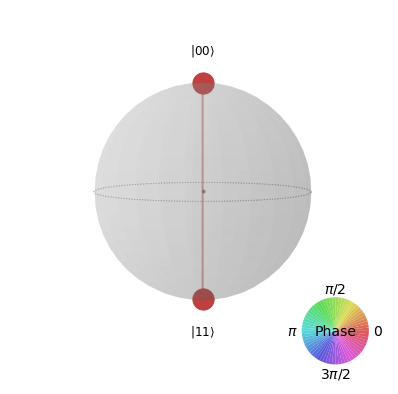

In [12]:
#For state |00>
qc = QuantumCircuit(2) # Create the quantum circuit with 2 qubits
create_bell_pair(qc, 0, 1, "00")
# show result on q-sphere
state = Statevector.from_instruction(qc)
print(state)
plot_state_qsphere(state)

Statevector([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j,
             0.        +0.j],
            dims=(2, 2))


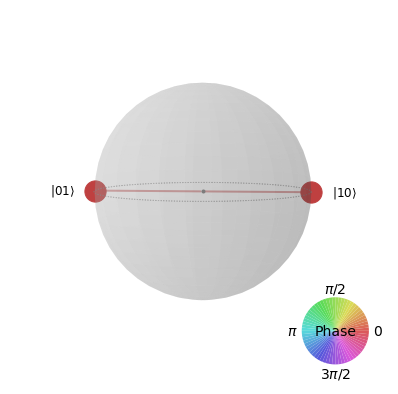

In [13]:
#For state |01>
qc = QuantumCircuit(2) # Create the quantum circuit with 2 qubits
create_bell_pair(qc, 0, 1, "01")
# show result on q-sphere
state = Statevector.from_instruction(qc)
print(state)
plot_state_qsphere(state)

Statevector([ 0.70710678+0.j,  0.        +0.j,  0.        +0.j,
             -0.70710678+0.j],
            dims=(2, 2))


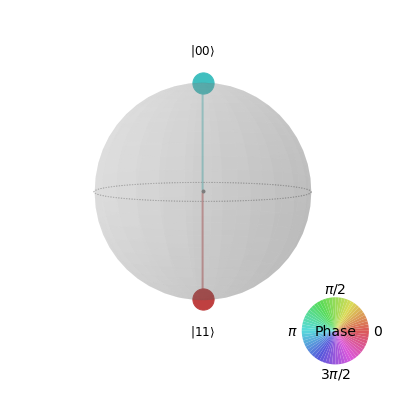

In [14]:
#For state |01>
qc = QuantumCircuit(2) # Create the quantum circuit with 2 qubits
create_bell_pair(qc, 0, 1, "10")
# show result on q-sphere
state = Statevector.from_instruction(qc)
print(state)
plot_state_qsphere(state)

Statevector([ 0.        +0.j, -0.70710678+0.j,  0.70710678+0.j,
              0.        +0.j],
            dims=(2, 2))


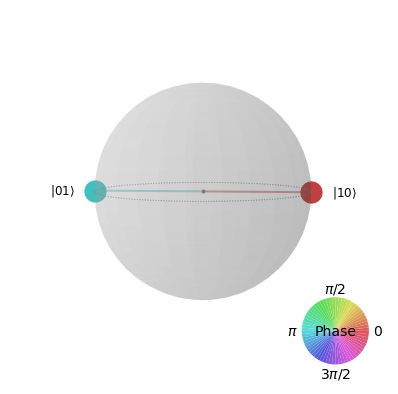

In [15]:
#For state |01>
qc = QuantumCircuit(2) # Create the quantum circuit with 2 qubits
create_bell_pair(qc, 0, 1, "11")
# show result on q-sphere
state = Statevector.from_instruction(qc)
print(state)
plot_state_qsphere(state)

(b) Does entanglement work for 3 qubits?

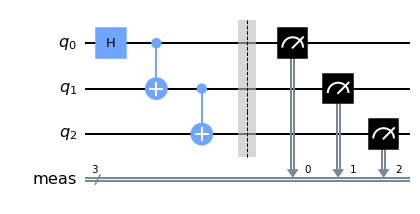

In [16]:
# Create the quantum circuit with 3 qubits
qc = QuantumCircuit(3)

# Entangle qubit 0 with qubit 1 and qubit 1 with qubit 2
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)

# measure the quantum circuit 
qc.measure_all()

# draw the quantum circuit
qc.draw(output = "mpl")

{'000': 493, '111': 531}


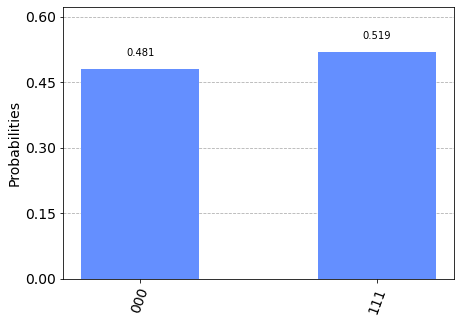

In [17]:
# setting up backend to measure to run circuit 
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024) # running circuit with 1024 shots
sim_result = job_sim.result() # simulating the results obtained
measurement_result = sim_result.get_counts(qc) # getting results based on quantum circuit
print(measurement_result)
plot_histogram(measurement_result)

Ans: Yes, Entanglement works for 3 qubits